# Laboratorium 7 - Detekcja krawędzi, Algorytm Canny'ego


W ramach laboratorium zostanie zaimplementowany jeden z najbardziej znanych algorytmów detekcji krawędzi - Algorytm Canny'ego.
Zacznijmy od importu przydatnych bibliotek oraz wygenerowania syntetycznego obrazu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import feature
from skimage import filters
from scipy import ndimage as nd, signal
import queue
%matplotlib inline

import scipy, os, sys
import cv2

y_size, x_size = 256, 256
image = np.zeros((y_size, x_size))
image[100:200, 100:200] = 1
image = image + np.random.randn(y_size, x_size)*0.02

Algortym Canny'ego jest zaimplementowany w bibliotece skimage.

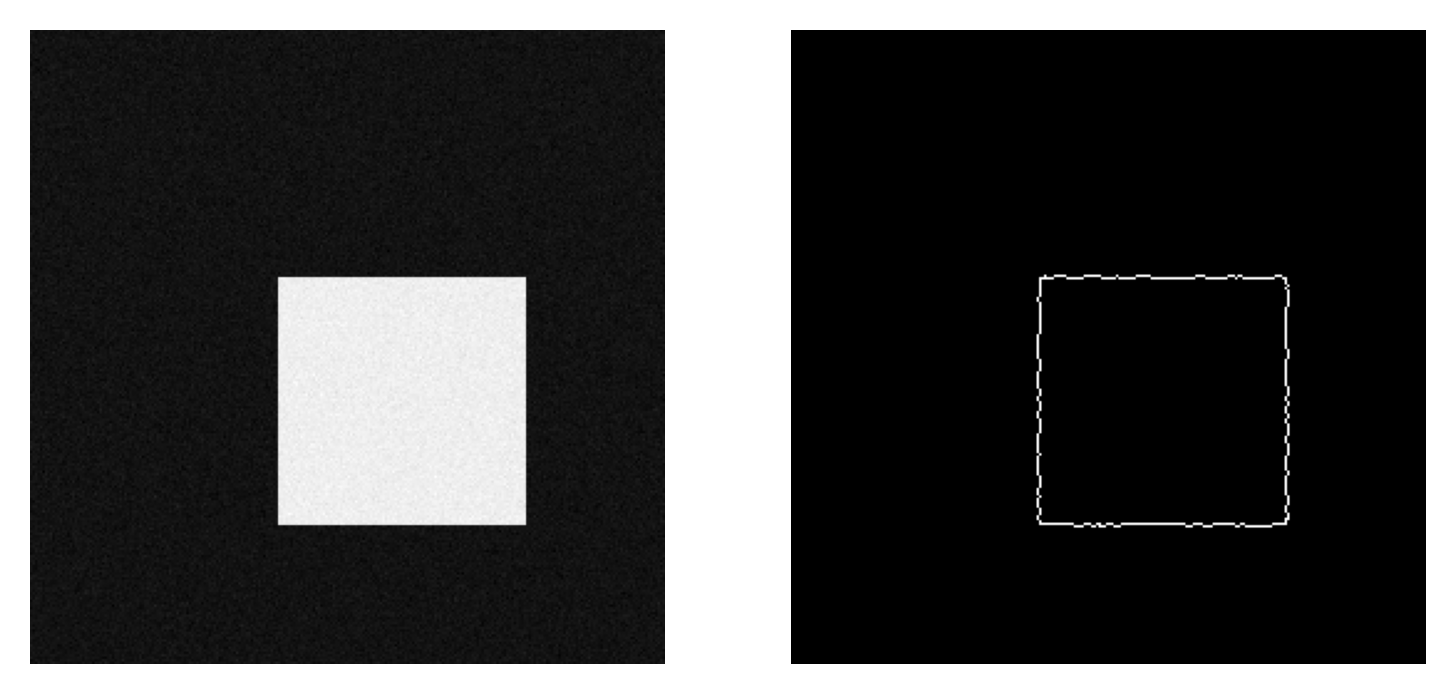

In [2]:
skimage_canny = feature.canny(image)
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(skimage_canny, cmap='gray')
plt.axis('off')
plt.show()

img = plt.imread('CT_lungs.png')
img = color.rgb2gray(img)

Celem laboratorium jest samodzielna implementacja przedstawionego algorytmu.
Uwaga: wyniki mogą różnić się od przedstawionych powyżej w zależności od przyjętych założeń i wewnętrznej implementacji filtracji Gaussa oraz doboru progu dolnego po algorytmie Otsu.
Szkielet funkcji będzie wyglądać następująco:


In [3]:
img = plt.imread('CT_lungs.png')
img = color.rgb2gray(img)

Powyższa funkcja będzie się składać z następujących podfunkcji:

In [4]:
def gaussian_smoothing(image, sigma):
    """
    TO DO - dokonaj filtracji image za pomoca filtru Gaussa o zadanej sigmie (wielkość filtru według konwencji - zazwyczaj przyjmuje się 2.54*sigma zaokrąglone do najbliższej nieparzystej      wartości w górę, chociaż równie dobrze może to być oddzielny, opcjonalny parametr)
    0.5p
    """
    filter_size = 2 * int(2.54*sigma) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_filter[x+m, y+n] = (1/x1)*x2
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    
    im_filtered = signal.convolve2d(image, gaussian_filter)
    return im_filtered


In [5]:
def calculate_gradients(image):
    """
    TO DO - Funkcja powinna zwrócić magnitude i kąt gradientu
    0.5p
    """
    vertical_mask = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    horizontal_mask = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    x_filter=signal.convolve2d(image,horizontal_mask)
    y_filter=signal.convolve2d(image,vertical_mask)
    
    gradient_magnitude = np.sqrt(y_filter**2+x_filter**2)
    gradient_angle = np.arctan2(y_filter,x_filter)
    return gradient_magnitude, gradient_angle

In [6]:
def non_maximum_supression(gradient_magnitude, gradient_angle):
    """
    TO DO - funkcja powinna wyznaczyć potencjalnie krawędzie korzystając z magntiudy i kąta gradientu
    0.5p
    """
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_angle[row, col]
 
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
    return output


In [7]:
def otsu_threshold(image):
    """
    TO DO - automatycznie wyznacz próg górny implementująć algorytm Otsu
    0.5p
    """
    val = filters.threshold_otsu(image)
    return val

def double_threshold(potential_edges, gradient_magnitude):
    
    upper_thres = otsu_threshold(potential_edges)
    lower_thres = upper_thres/3
    row,col = gradient_magnitude.shape
    strong_edges = np.zeros(gradient_magnitude.shape)
    weak_edges = np.zeros(gradient_magnitude.shape)

    for i in range(row-1):
        for j in range(col-1):
            if(potential_edges[i][j]>upper_thres):
                strong_edges[i][j]=1
            if((potential_edges[i][j]>lower_thres) and (potential_edges[i][j]<upper_thres)):
                weak_edges[i][j]=1
    return strong_edges, weak_edges

In [8]:
def edge_hysteresis(strong_edges, weak_edges):
    """
    TO DO - dokonaj histerezy krawędzi silnych i słabych. Powinny pozostać tylko krawędzie silne oraz te krawędzie słabe, które są połączone z jakąkolwiek krawędzią silną (również przez krawędź słabą)
    0.5p
    Wskazówka: Funkcja będzie niemal identyczna z algorytmem rozrostu obszarów w wersji lokalnej z poprzedniego laboratorium
    """
    
    edges = np.zeros(strong_edges.shape)
    edges[strong_edges != 0] = True
    strong_edges[strong_edges != 0] = 255
    strong = 1.0
    M, N = strong_edges.shape
    for i in range(1,M-2):
        for j in range(1,N-2):
            if weak_edges[i, j]!=0:
                # check if one of the neighbours is strong (=255 by default)
                try:
                    if ((strong_edges[i + 1, j] == strong) or (strong_edges[i - 1, j] == strong)
                         or (strong_edges[i, j + 1] == strong) or (strong_edges[i, j - 1] == strong)
                         or (strong_edges[i+1, j + 1] == strong) or (strong_edges[i-1, j - 1] == strong)):
                        edges[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return edges

Finalnie korzystając z powyższych funkcji zaimplementuj funkcję canny:

In [9]:
def canny(image, sigma=1.0):
    ### gaussian_smoothing ###
    image_smoothed = gaussian_smoothing(image, sigma)
    #plots
    plt.figure(figsize = (14,14))
    plt.subplot(1,3,1)
    plt.imshow(image_smoothed, cmap="gray")
    plt.title("filtered")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img, cmap="gray")
    plt.title("orginal")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(scipy.ndimage.gaussian_filter(image, sigma), cmap="gray")
    plt.title("wbudowana funkcja")
    plt.axis('off')
    
    ### gradients ###
    image_gradients, image_angles = calculate_gradients(image_smoothed)
    #plos
    plt.figure(figsize = (14,14))
    plt.subplot(1,2,1)
    plt.imshow(image_gradients, cmap="gray")
    plt.title("magnitude")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image_angles, cmap="gray")
    plt.title("angle")
    plt.axis('off')
    
    ### non_maximum_supression ###
    potential_edges = non_maximum_supression(image_gradients, image_angles)
    plt.figure(figsize = (10,10))
    plt.imshow(potential_edges, cmap="gray")
    plt.title("non maximum supression")
    plt.axis('off')
    
    ### double_threshold with otsu inside ###
    strong_edges, weak_edges = double_threshold(potential_edges, image_gradients)
    #plots
    plt.figure(figsize = (20,20))
    plt.subplot(1,2,1)
    plt.imshow(strong_edges, cmap="gray")
    plt.title("strong")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(weak_edges, cmap="gray")
    plt.title("weak")
    plt.axis('off')
    ### edge_hysteresis ###
    edges = edge_hysteresis(strong_edges, weak_edges)
    #plots
    plt.figure(figsize = (10,10))
    plt.imshow(edges, cmap="gray")
    plt.axis('off')
    
    return edges

Porównaj działanie zaimplementowanej funkcji na wygenerowanym oraz wczytanym obrazie:

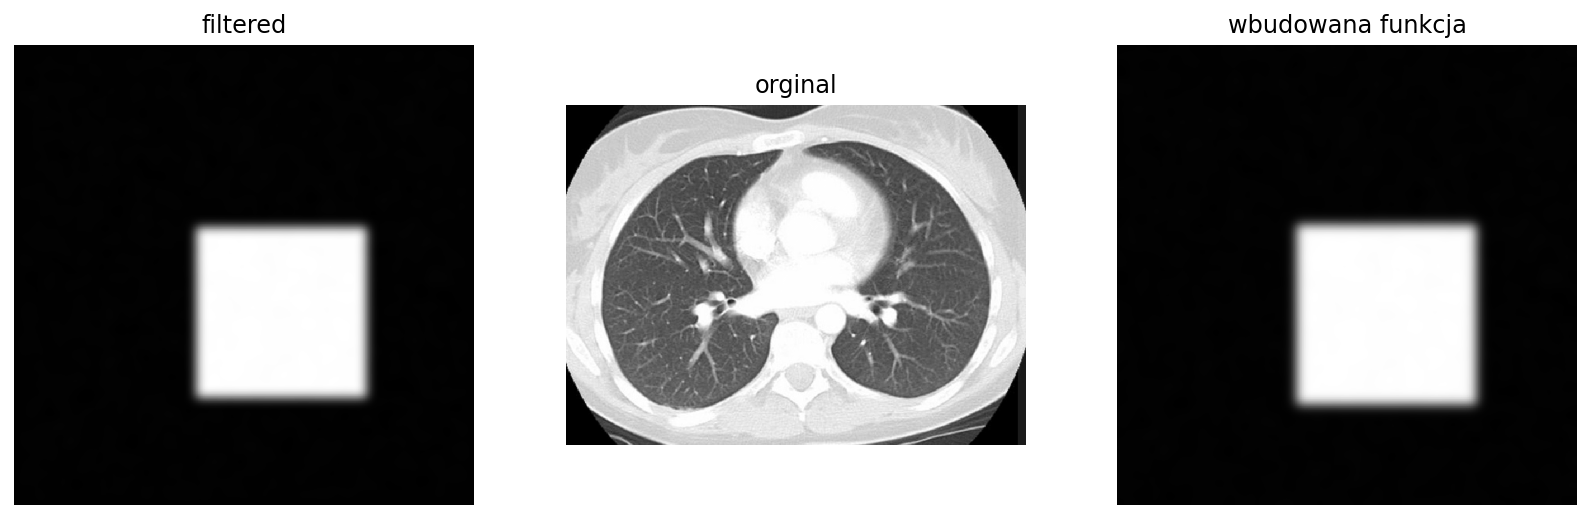

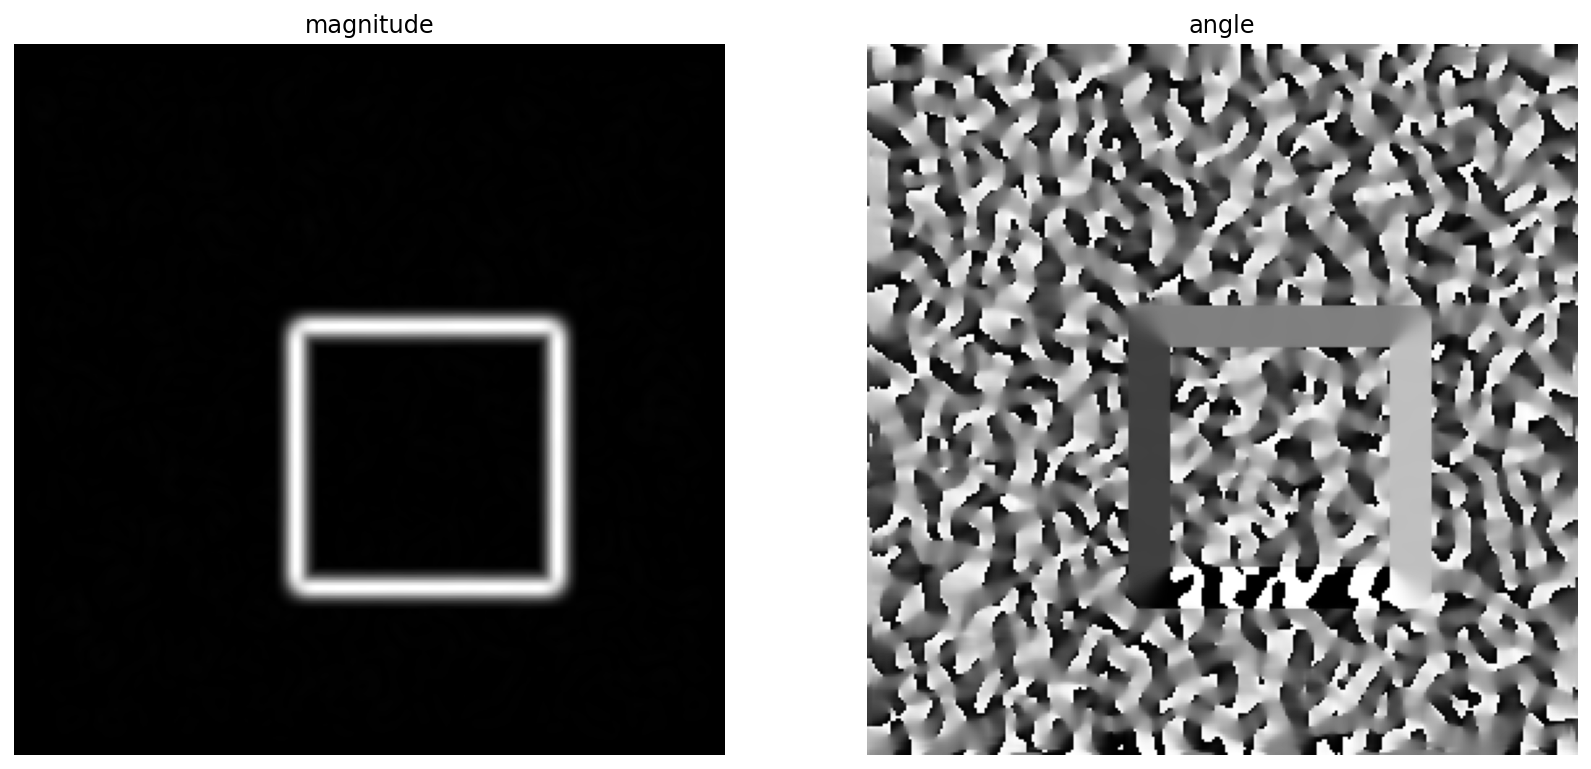

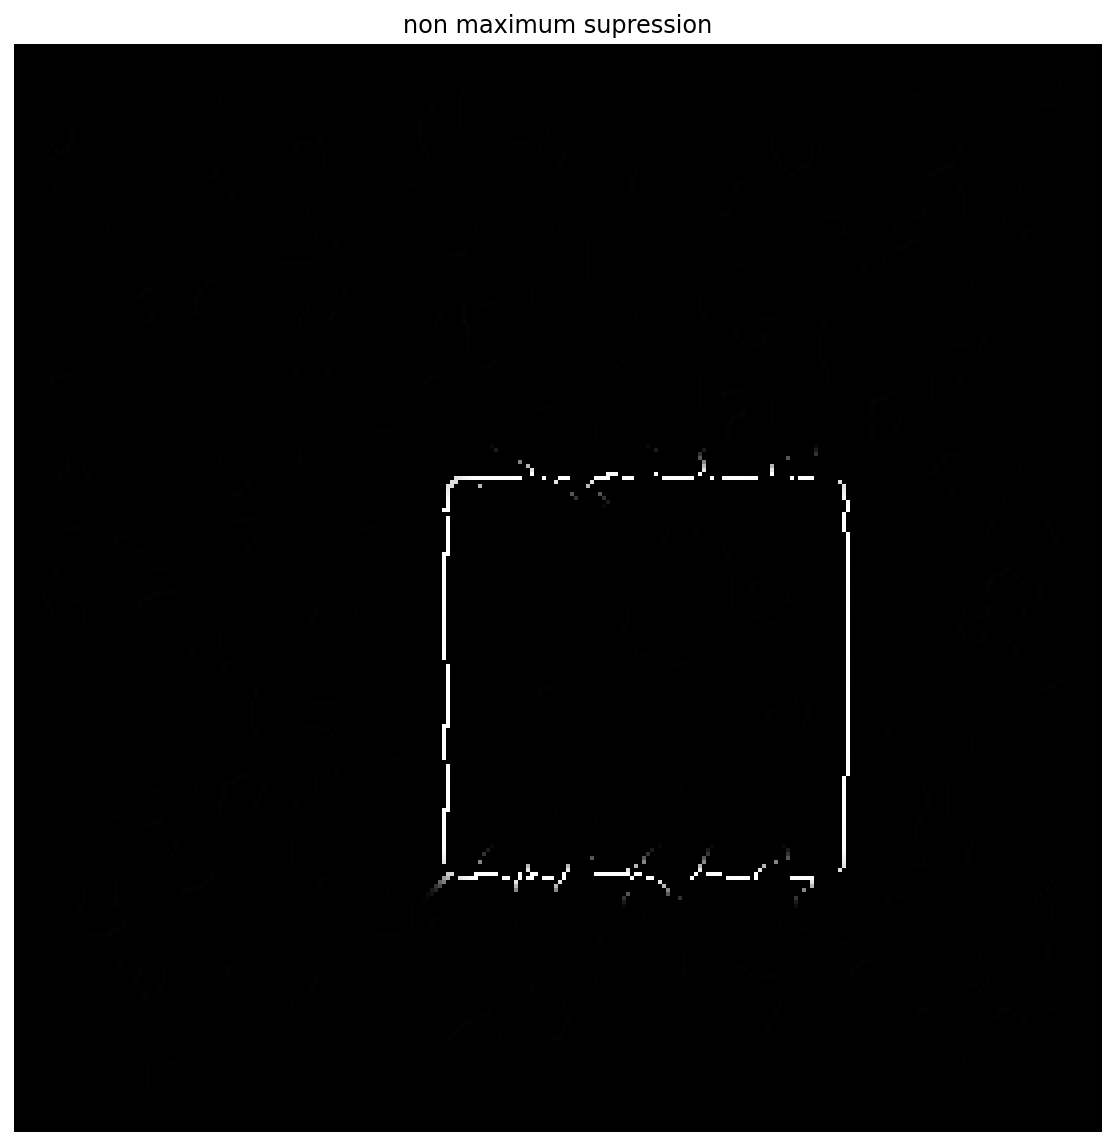

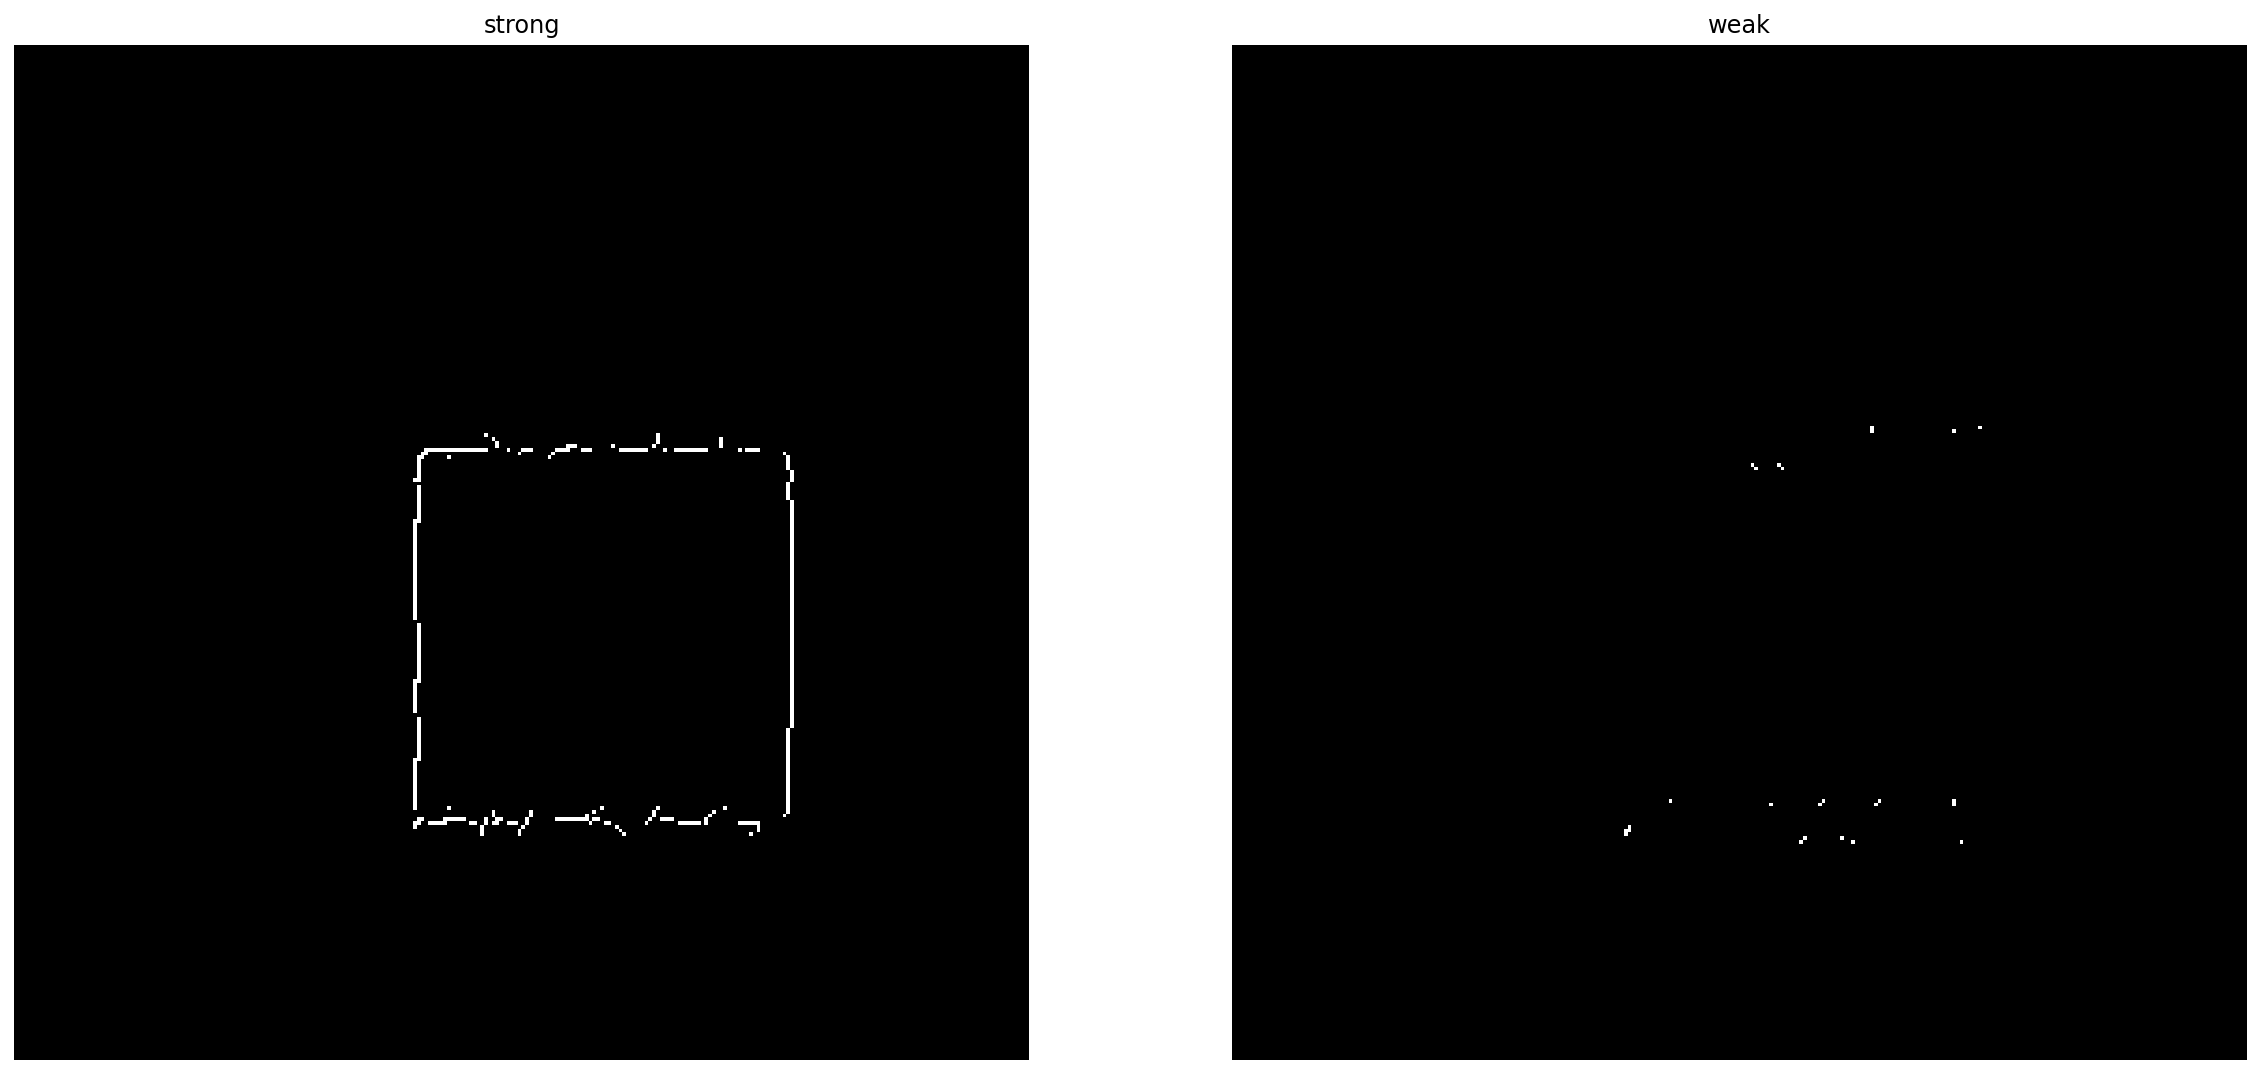

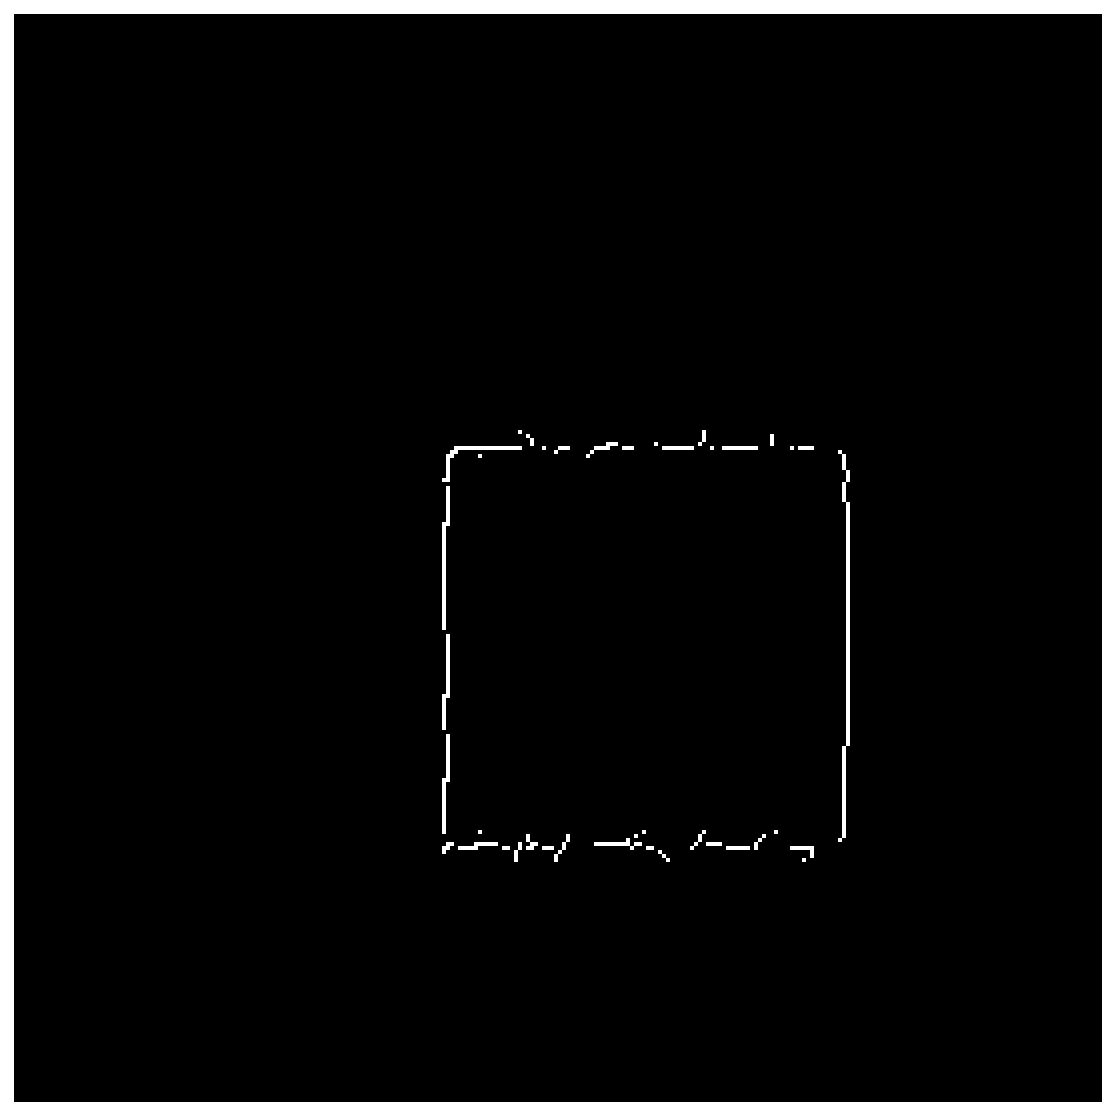

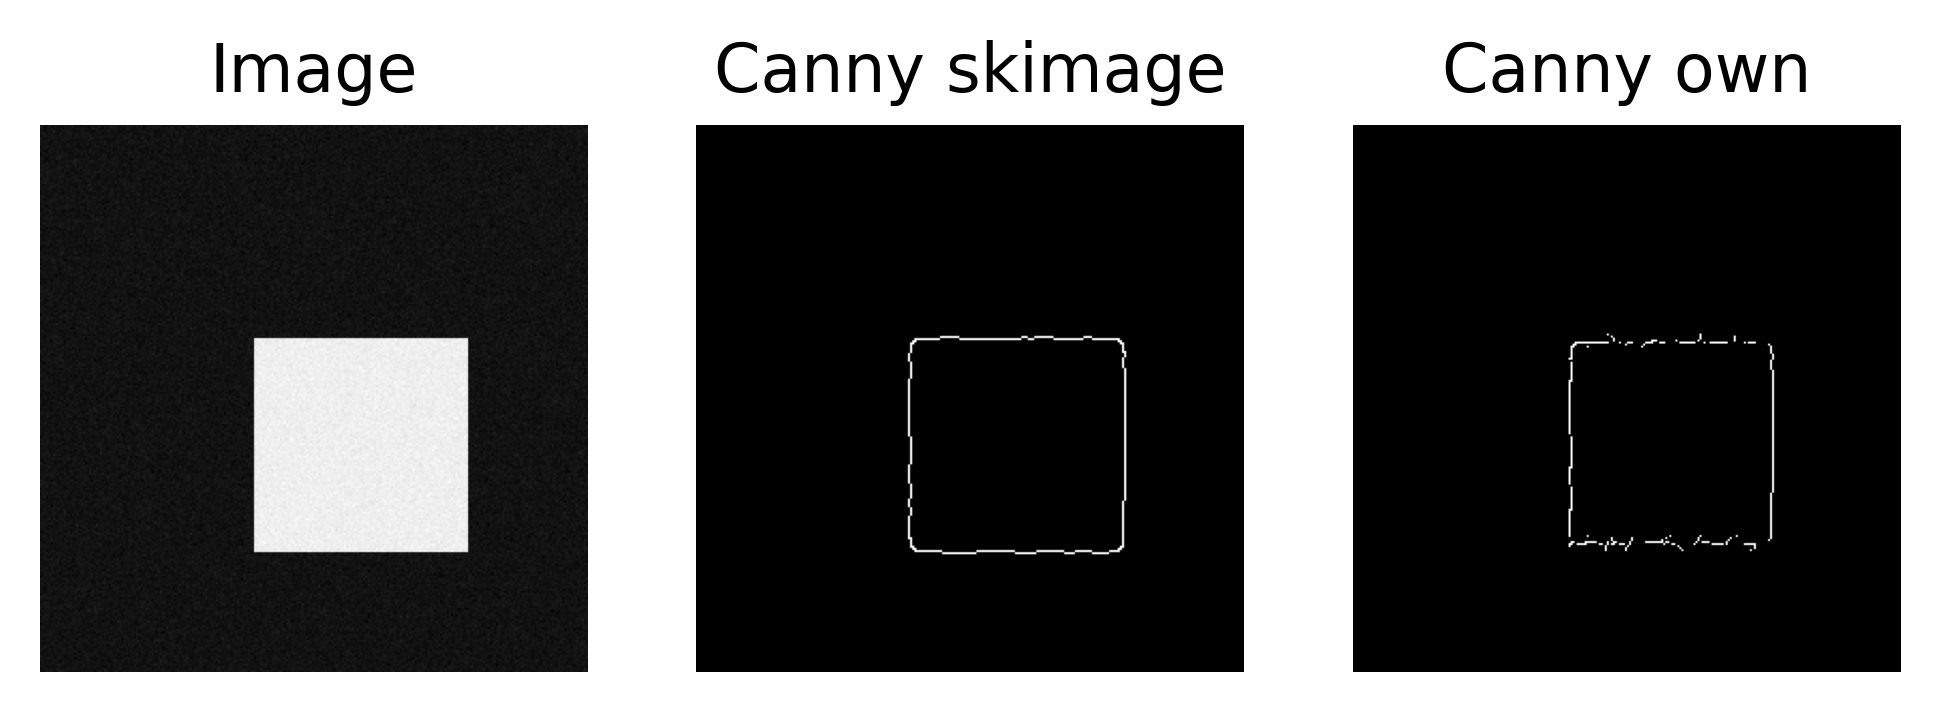

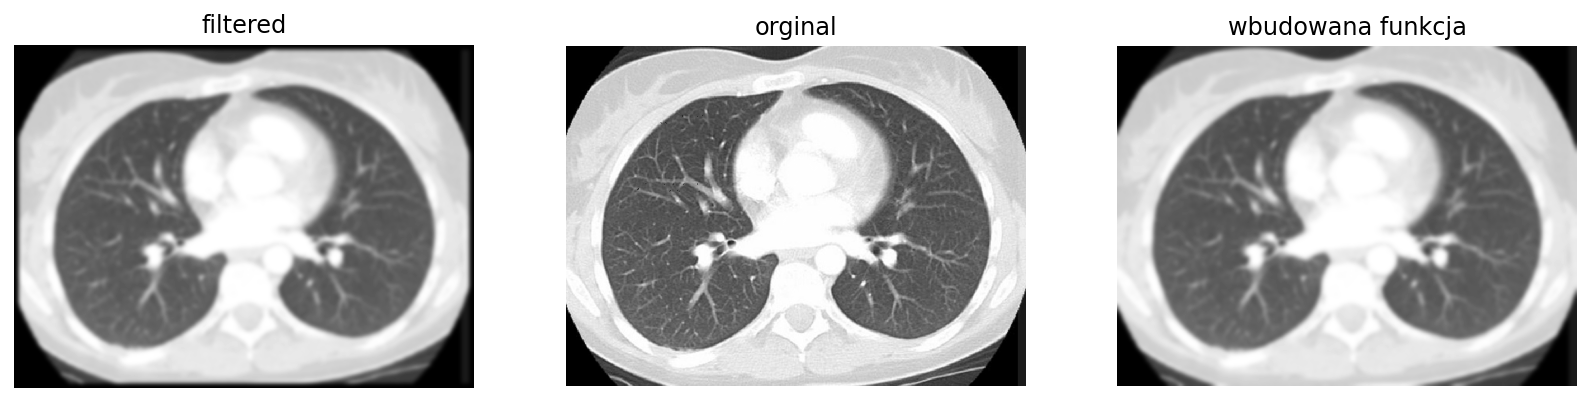

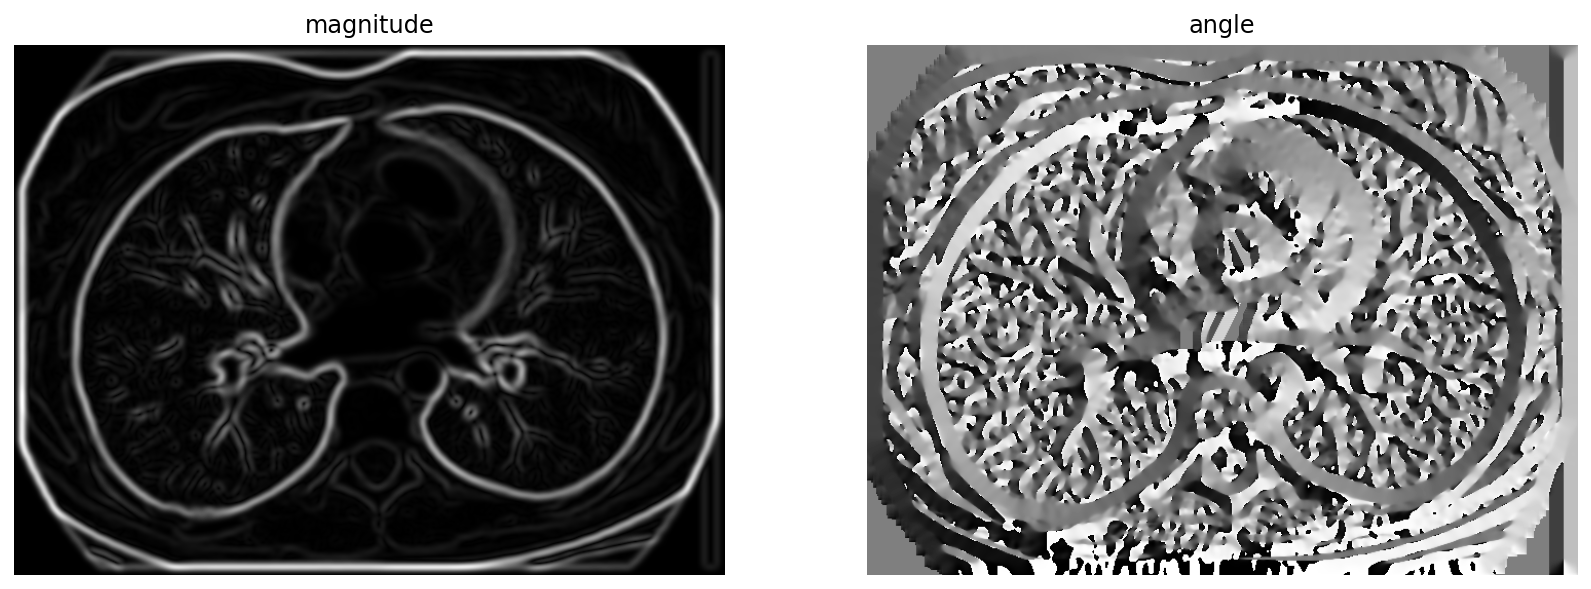

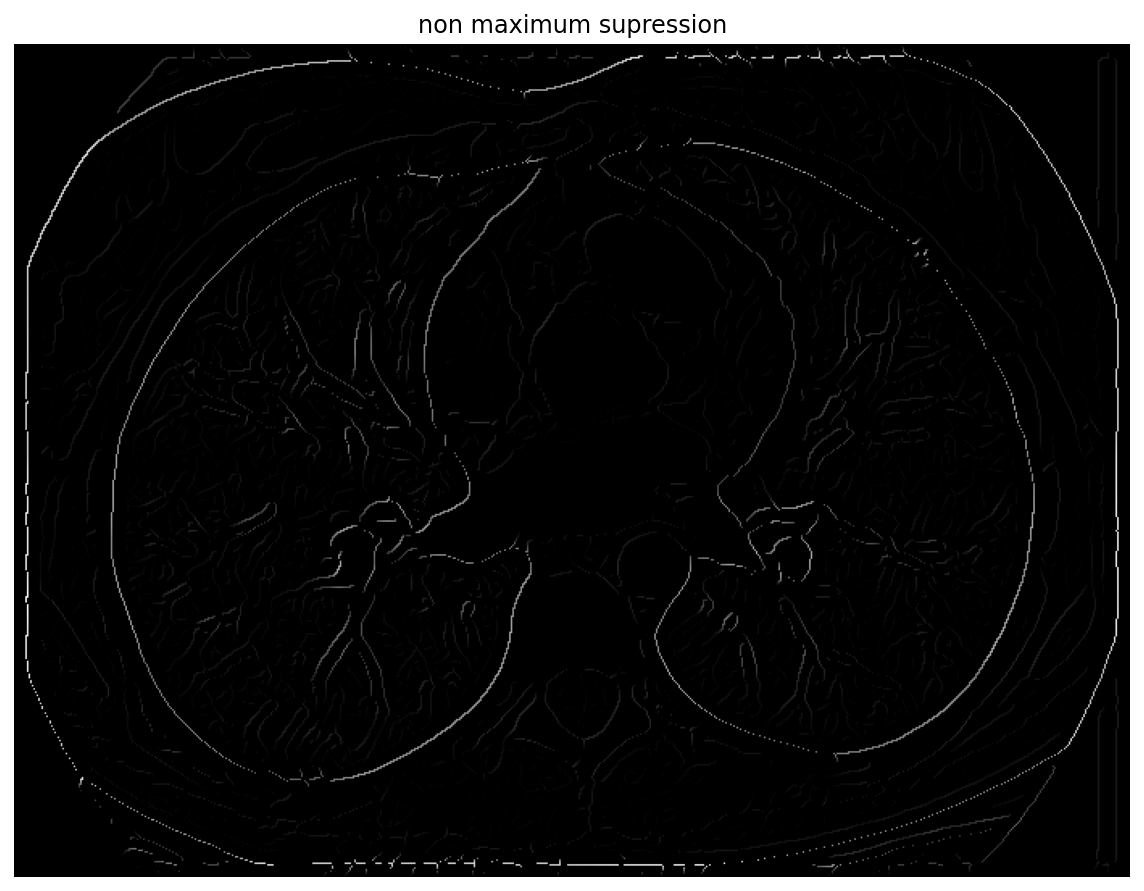

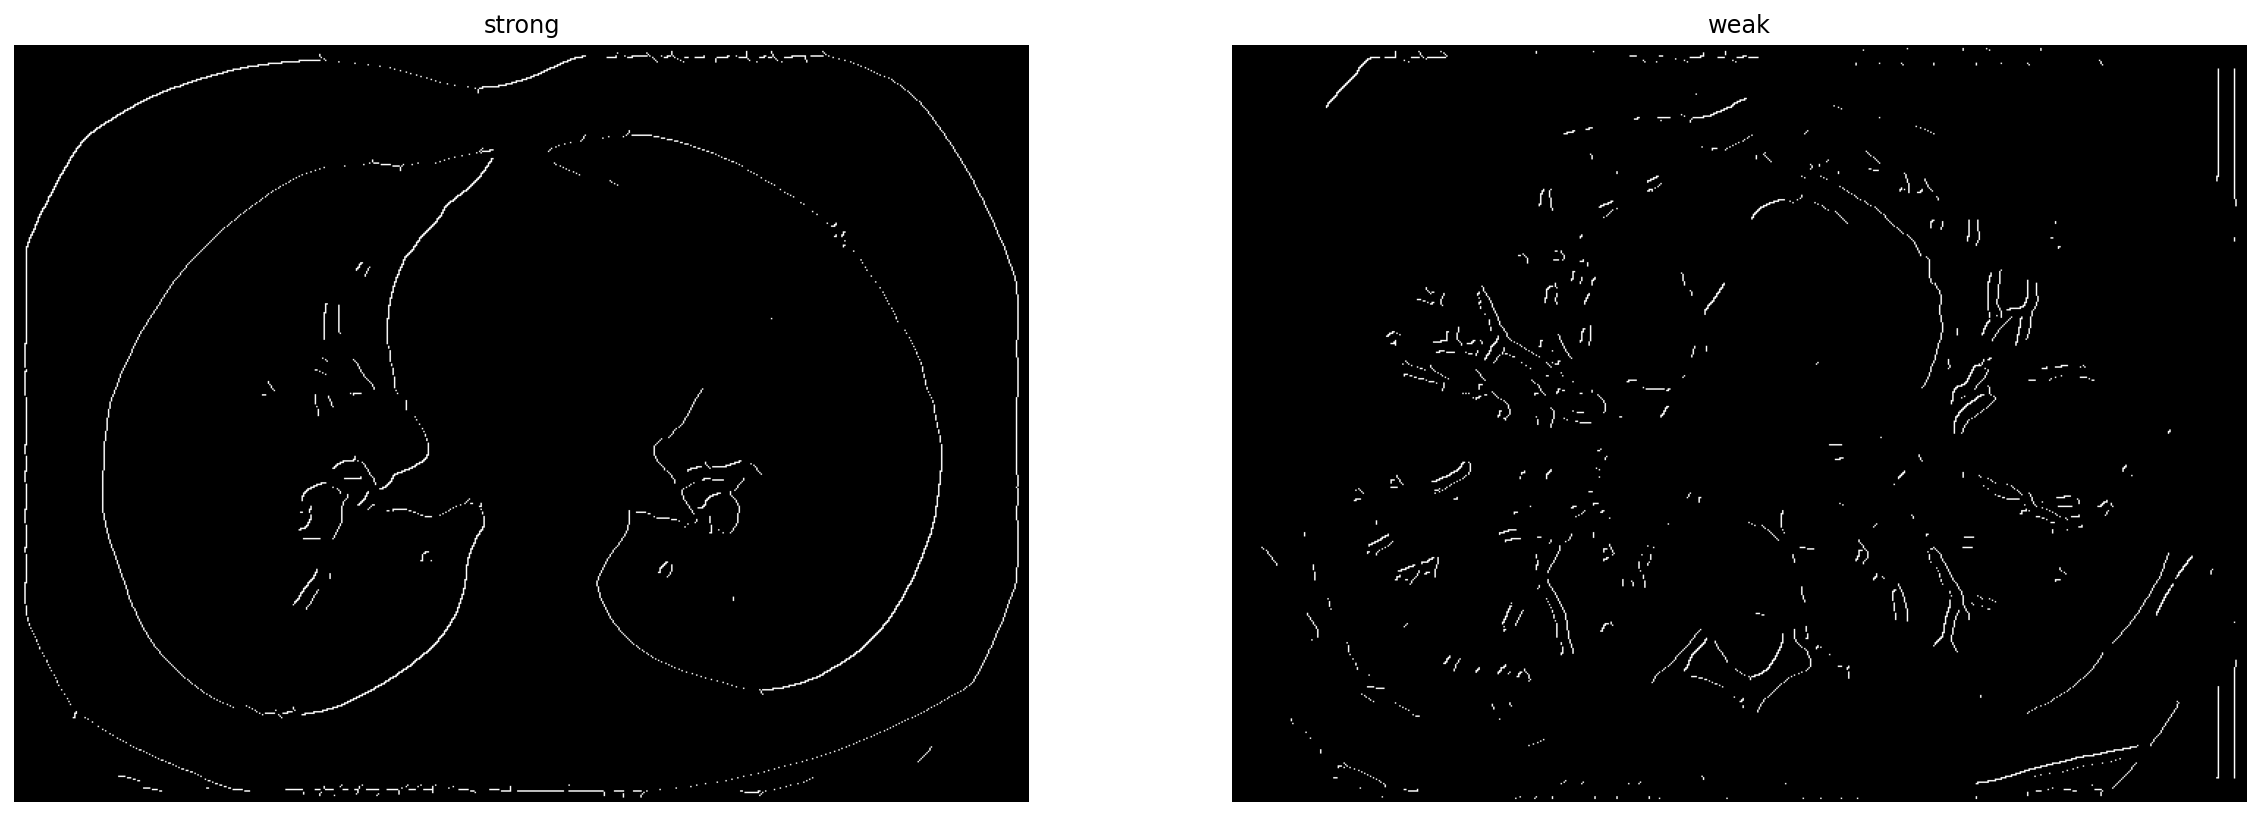

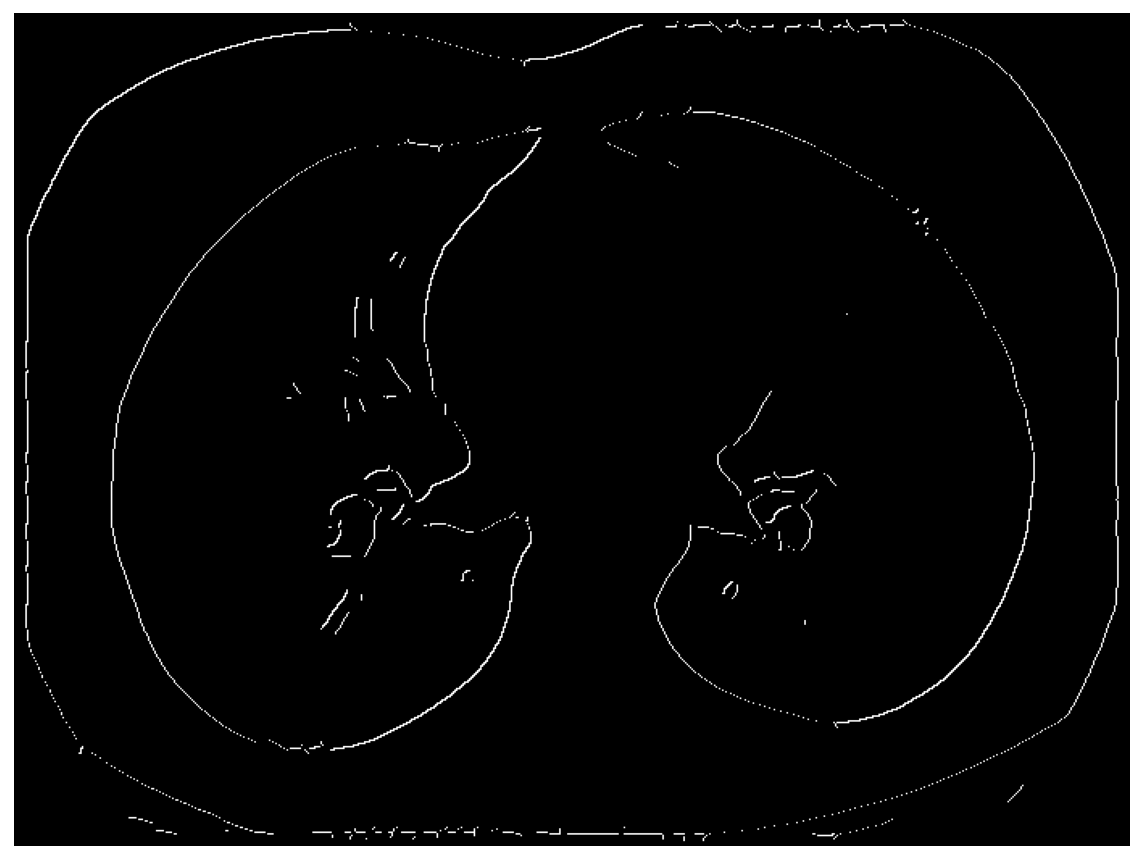

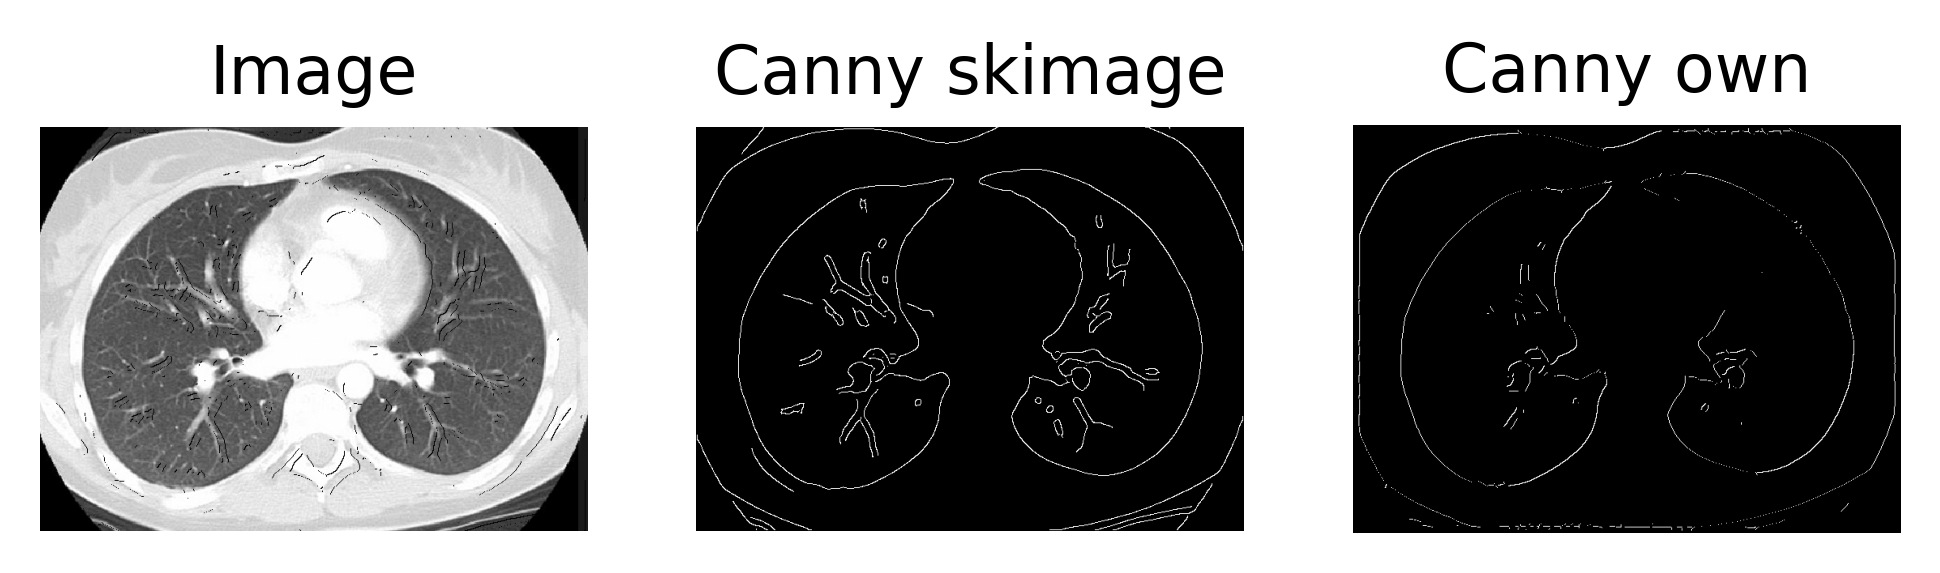

In [11]:
images = [image, img]
# Krawędzie mają grubość jednego pixela, nie wszystkie muszą być widoczne (ustawienia wyświetlania). Aby zobaczyć wszystkie krawędzie zwiększ dpi rysunku.
for current_image in images:
    skimage_canny = feature.canny(current_image, sigma=3)
    own_canny = canny(current_image, sigma=3)
    plt.figure(dpi=200)
    plt.subplot(1, 3, 1)
    plt.imshow(current_image, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(skimage_canny, cmap='gray')
    plt.title("Canny skimage")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(own_canny, cmap='gray')
    plt.title("Canny own")
    plt.axis('off')
    plt.show()